## Imports and matplotlib config

Also sets rng seed for reproducible research

In [1]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import pickle
import scipy.stats as sps
import seaborn as sns
import seaborn.distributions as snsd


from algorithms.confidence_ss import confidenceMCMC 
from algorithms.confidence_ss import confidenceMCMCWithProxy
from algorithms.confidence_ss import confidenceMCMCWithProxyDroppedAlong
from algorithms.iss import iss_mcmc
from algorithms.utils import chain_error
from algorithms.vanillaMH import vanillaMH

In [3]:
sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
saveDirStr = "scaling_figs"
npr.seed(1)

# Smallest and largest exponents of 10 we test for sample size
small_exp = 2
large_exp = 4
exp_step= 0.5


# Scaling Experiment
### Generate parent sample

In [4]:
sample_sizes_tested = [int(10**exp) for exp in np.arange(small_exp,large_exp+1,exp_step)]
max_samples = int(10**large_exp)
no_experiments = len(sample_sizes_tested)
# Here is where we make the model mis-specified if we wish to
dataType = "Gaussian"
if dataType == "Gaussian":
    parent_x = npr.randn(max_samples)
elif dataType == "logNormal":
    parent_x = npr.lognormal(0,1,size=max_samples)
elif dataType == "laplace":
    parent_x = npr.laplace(0,math.pow(0.5,0.5),size=max_samples)


### Generate references across experiments using VanillaMH

In [5]:
try:
    print('Trying to load existing references')
    ref_chains = pickle.load(open('ref_chains.p', 'rb'))
    print('refchains loaded')
    experiment_samples = pickle.load(open('experiment_samples.p', 'rb'))
    print('samples loaded')
    experiment_MLEs = pickle.load(open('experiment_MLEs.p', 'rb'))
    print('MLEs loaded')
except FileNotFoundError:
    print('Cannot fine one or more existing references - regenerating.')

    REFERENCE_CHAIN_LENGTH = int(50*10**3)
    ref_chains = list()
    experiment_samples = list()
    experiment_MLEs = list()

    for i in sample_sizes_tested:
        # Watch out - python list and numpy array have append mean smth different
        experiment_samples.append(parent_x[:int(i)])

    for i, x in enumerate(experiment_samples):
        print(f'Generating reference with {sample_sizes_tested[i]:.2E} samples')
        realMean = np.mean(x)
        realStd = np.std(x)
        initial_theta = np.array([realMean,np.log(realStd)])
        experiment_MLEs.append(initial_theta)
        ref_chains.append(vanillaMH(initial_theta,x,time_budget=np.inf,chain_length=REFERENCE_CHAIN_LENGTH)[0])

    # To avoid losing these if we clear the notebook, pickle em
    print('Saving pickles to avoid having to recompute')
    pickle.dump(ref_chains,open('ref_chains.p', 'wb'))
    print('refchains saved')
    pickle.dump(experiment_samples,open('experiment_samples.p', 'wb'))
    print('experiment_samples saved')
    pickle.dump(experiment_MLEs,open('experiment_MLEs.p', 'wb'))
    print('experiment_MLEs saved')

Trying to load existing references
refchains loaded
samples loaded
MLEs loaded


### Run experiments for varying N across all algorithms of interest

In [6]:
import importlib

EXPERIMENT_MAX_CHAIN_LENGTH = int(10**6)
EXPERIMENT_TIME_BUDGET = 5 # seconds

def run_experiment(algorithm):
    mean_errors = []
    std_errors = []
    for i, x in enumerate(experiment_samples):
        ref_chain = ref_chains[i]
        print(f'Running experiment with N = {sample_sizes_tested[i]:.2E}, time budget {EXPERIMENT_TIME_BUDGET}, max chain length {EXPERIMENT_MAX_CHAIN_LENGTH}')
        initial_theta = experiment_MLEs[i]
        chain, _ = algorithm(initial_theta, x, time_budget=EXPERIMENT_TIME_BUDGET, chain_length=EXPERIMENT_MAX_CHAIN_LENGTH)
        mean_errors.append(chain_error(ref_chain[:,0],chain[:,0]))
        std_errors.append(chain_error(ref_chain[:,1],chain[:,1]))
    return (mean_errors, std_errors)


In [7]:
mh_results = run_experiment(vanillaMH)

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 89515, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 85590, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 74666, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 54369, returning truncated result
Running experiment with N = 1.00E+04, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 30665, returning truncated result
Running experiment with N = 3.16E+04, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at c

In [8]:
iss_results = run_experiment(iss_mcmc)

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Running ISS with n = 10, k = 3
Iteration 0 Theta Acceptance 0.0 Sample Acceptance 0.0
Time budget consumed at chain step 33144, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Running ISS with n = 17, k = 4
Iteration 0 Theta Acceptance 1.0 Sample Acceptance 0.0
Time budget consumed at chain step 29602, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Running ISS with n = 31, k = 5
Iteration 0 Theta Acceptance 1.0 Sample Acceptance 1.0
Time budget consumed at chain step 24543, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Running ISS with n = 56, k = 7
Iteration 0 Theta Acceptance 1.0 Sample Acceptance 1.0
Time budget consumed at chain step 14572, returning truncated result
Running experiment with N = 1.00E+04, time budget 5, max chain lengt

In [9]:
ics_results = run_experiment(confidenceMCMC)

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 200.0 sigma/sqrt(n) 0.002664955630916714 R/n 0.0015304017204704407
Time budget consumed at chain step 8715, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 632.0 sigma/sqrt(n) 0.00039689819612797895 R/n 0.00016151698272317823
Time budget consumed at chain step 9082, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 2000.0 sigma/sqrt(n) 0.0006229121501404578 R/n 0.00021957999011983095
Time budget consumed at chain step 7043, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 0.0 Avg. num evals 6324.0 sigma/sqrt(n) 0.00020371779165771 R/n 2.803637536097492e-05
Time budget consumed at chain step 5967, r

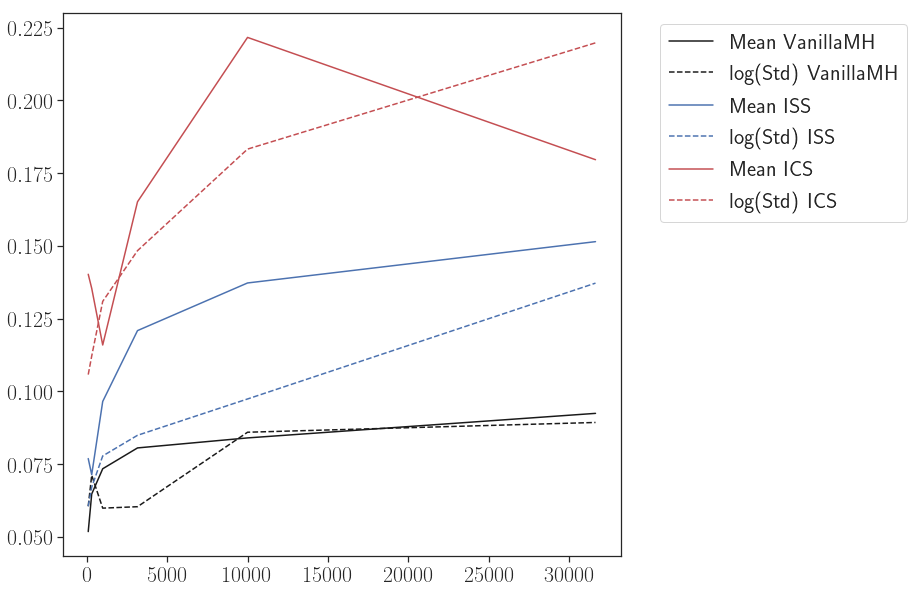

In [21]:
plt.plot(
    sample_sizes_tested, mh_results[0], 'k',
    sample_sizes_tested, mh_results[1], '--k',
    sample_sizes_tested,iss_results[0], 'b',
    sample_sizes_tested,iss_results[1], '--b',
    sample_sizes_tested,ics_results[0], 'r',
    sample_sizes_tested,ics_results[1], '--r'
)
plt.legend(('Mean VanillaMH', 
            'log(Std) VanillaMH',
            'Mean ISS',
            'log(Std) ISS',
            'Mean ICS',
            'log(Std) ICS'),
        bbox_to_anchor=(1.05, 1))
plt.show()